GMClustering is a pipeline of unsupervised methods that automatically separates measurements from MMS and THEMIS into different plasma regions, being the magnetosphere, the magnetosheath, and the solar wind. It's meant to simply provide predictions for data and offer visualizations and making it an overall simple and easy experience.

This Jupyter notebook covers how to use this package on a small sample dataset, the MMS measurements processed for 2017. For our model training, we averaged measurements down to 1 minute resolution and only analyzed data between 7 <= R <= 35 RE, and this dataset reflects that.

# Getting Started

First, let's import the necessary packages

In [1]:
from gmclustering import GMClustering, utils
# for additional visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

The sample MMS dataset is included along with this package and can be loaded using the utils module.

In [2]:
dat = utils.load_example_data()

We can quickly visualze the positions of MMS1 in this dataset with a bivariate histogram

<Axes: xlabel='X', ylabel='Y'>

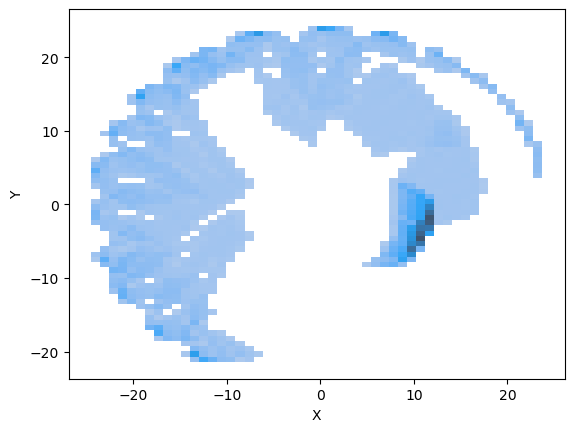

In [3]:
sns.histplot(dat, x='X', y='Y')

Now let's prepare the clustering model to analyze this data

In [4]:
gmc = GMClustering()

The SOM nodes used to represent the original dataset have been trained and so are static. Data is not required to analyze the clustering of the nodes in-of-themselves

(<Figure size 640x480 with 3 Axes>, <Axes: >)

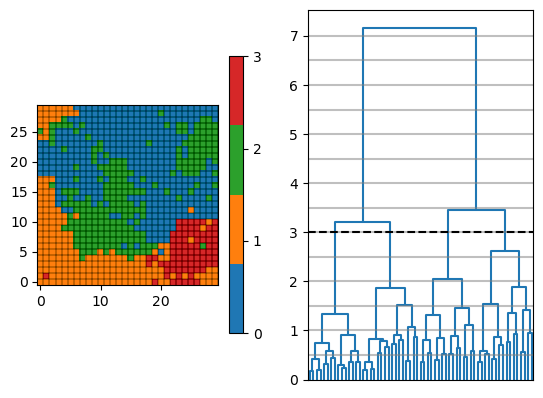

In [5]:
gmc.prepare_aggclust()
fig, axes = plt.subplots(1, 2)
gmc.som_clust(ax=axes[0])
dendrogram_kws = {'truncate_mode':'level', 'p':5}
gmc.dendrogram(ax             = axes[1],
               dendrogram_kws = dendrogram_kws)

As stated in the paper, the solar wind cluster is red (3), the magnetosheath cluster is orange (2), and the magnetosphere is in two clusters: green (2) for higher mach number and blue (1) for lower. The dendrogram on the right shows how the clustering solution on the SOM nodes is made with a hierarchical agglomerative clustering model with a ward linkage. Using a threshold distance of 3 intersects four lines horizontally on the dendrogram, so this will yield four clusters.

# Making a Prediction

To make a prediction, the magnetic field components in GSE (BX,BY,BZ), the ion velocity components in GSE (VX,VY,VZ), the ion temperature (T) and the ion density (n) are required. The format used for handling the data is pandas, so these relevant data should be handled using a pandas dataframe.

Making a prediction (using the default clustering solution) is as simple as calling a predict function

In [6]:
gmc.predict(dat)

100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


array([1., 1., 1., ..., 1., 1., 1.])

Part of the pipeline of models involves compute higher-order nonlinear features, before collapsing the dataset back down dimensionally to make a prediction. If memory is an issue for you and the arrays can't be broadcasted all at once, then you can process the data in batches using the 'rows_per_batch' keyword.

In [7]:
preds = gmc.predict(dat, rows_per_batch = 10**4)

100%|██████████| 15/15 [00:00<00:00, 24.04it/s]


# Visualizing Solutions

The utils module contains several functions for visualizing the solutions. There are a lot of points for a scatter plot, so it's better to use a bivariate histogram:

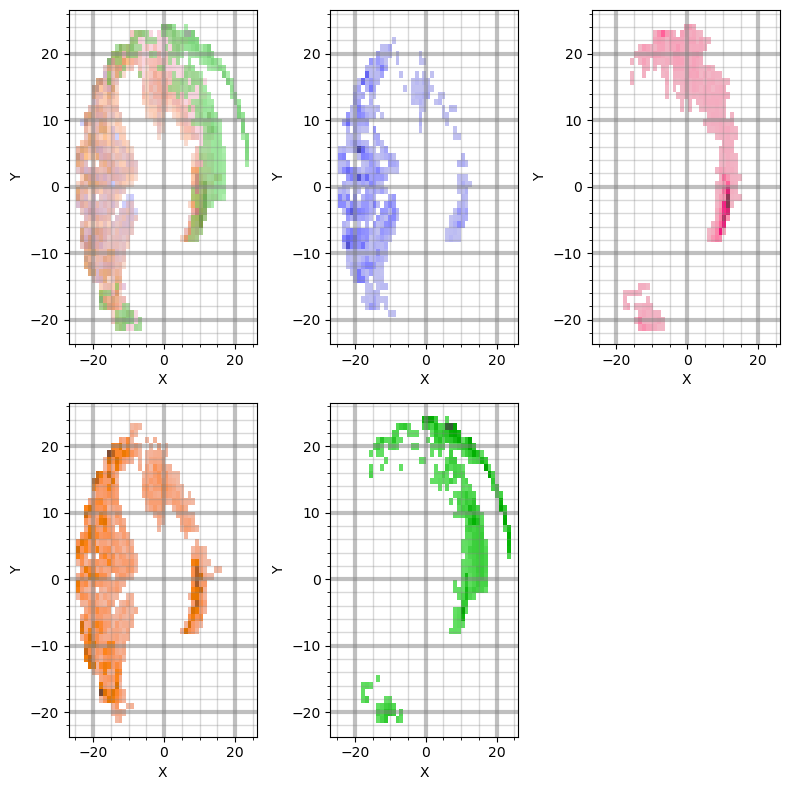

(<Figure size 800x800 with 6 Axes>,
 array([[<Axes: xlabel='X', ylabel='Y'>, <Axes: xlabel='X', ylabel='Y'>,
         <Axes: xlabel='X', ylabel='Y'>],
        [<Axes: xlabel='X', ylabel='Y'>, <Axes: xlabel='X', ylabel='Y'>,
         <Axes: >]], dtype=object))

In [8]:
# visualize predictions with a histogram over the clusters
utils.plot_xy_preds(dat, preds,
                    xy = ['X','Y'])

Additionally, 1d histograms can be used to depict the solutions.

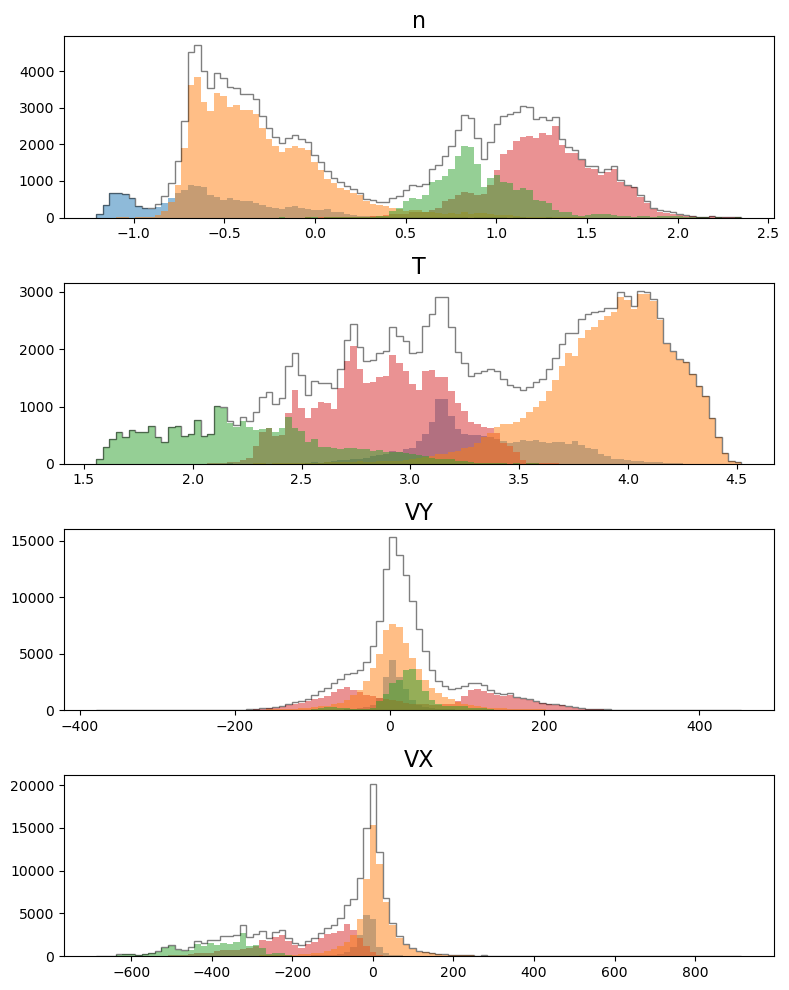

In [9]:
# visualize clusters as subsets of 1d histograms
fig, axes = utils.hist1d_vars(dat, preds,
                              hist_vars = ['n','T','VY','VX'],
                              logx      = ['n','T'],
                              fig_kws = {'figsize':(8,10)})
fig.tight_layout()

# Analyzing Sub-Clusters

The advantage of hierarchical analysis is that we can analyze sub-clusters of larger clusters. Getting clusters from the algorithm requires specifying a threshold distance and what cluster to unpack.

In [10]:
# Prepare tuple of distance to cutoff at and cluster to analyzer
sw_cluster = 3
original_distance = GMClustering.default_aggclust_dist
subset = (original_distance, sw_cluster)

gmc.prepare_aggclust(subset=subset)

Before we specify a distance for the sub-clustering, we can inspect the dendrogram to see what might be a good cutoff distance

(<Figure size 600x600 with 1 Axes>, <Axes: >)

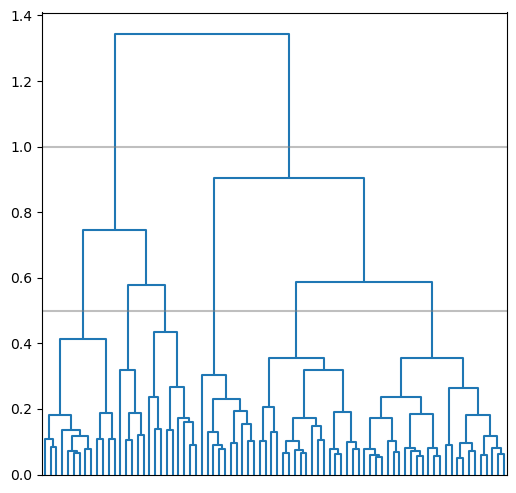

In [11]:
gmc.dendrogram()

1.0 seems like a sensible value to get a couple of subclusters, so let's try that

In [12]:
gmc.prepare_aggclust(subset=subset, dist=1.0)

(<Figure size 640x480 with 3 Axes>, <Axes: >)

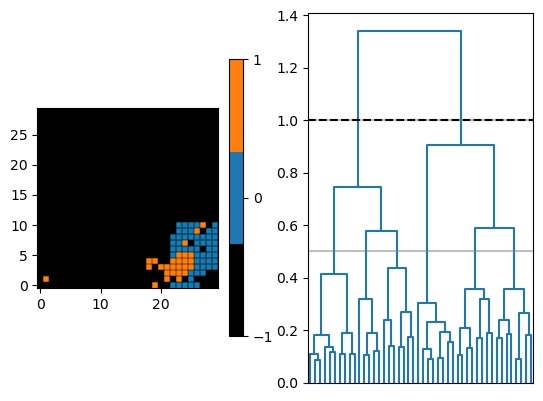

In [13]:
fig, axes = plt.subplots(1, 2)
gmc.som_clust(ax=axes[0])
gmc.dendrogram(ax             = axes[1],
               dendrogram_kws = dendrogram_kws)

The solar wind cluster was broken into 2 sub clusters. Nodes not belonging to the solar wind cluster are labeled with a -1 (in black). The other nodes are colored according to their grouping.

We can also get direct predictions for data relative to this clustering.

In [14]:
subpreds = gmc.predict(dat)

# filter out data that was assigned -1
subdat = dat[subpreds != -1]
subpreds = subpreds[subpreds != -1]

# get counts of predictions
np.unique(subpreds, return_counts=True)

100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


(array([0., 1.]), array([16003,  8139]))

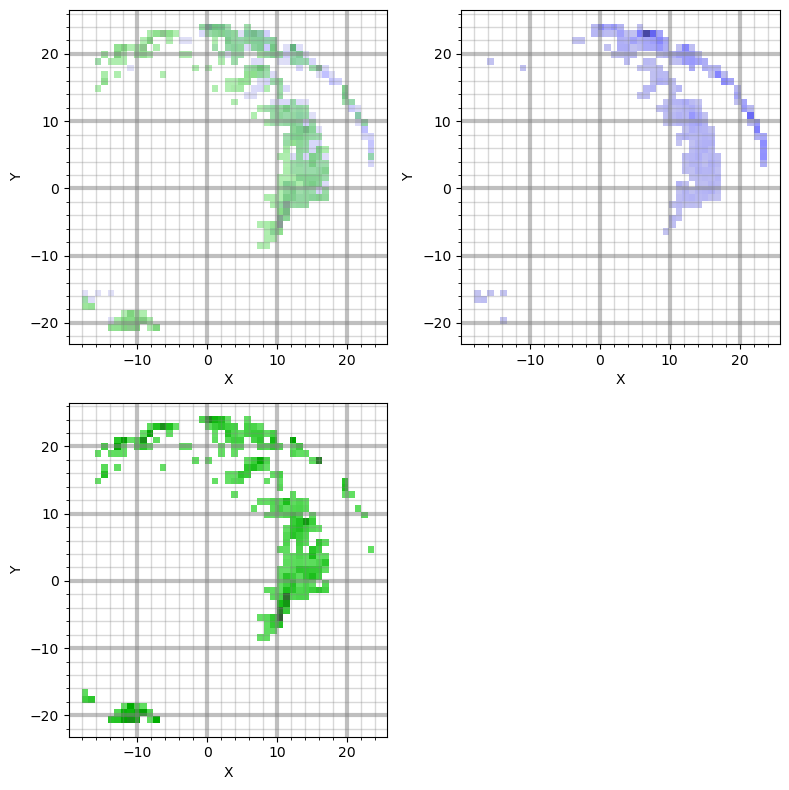

(<Figure size 800x800 with 4 Axes>,
 array([[<Axes: xlabel='X', ylabel='Y'>, <Axes: xlabel='X', ylabel='Y'>],
        [<Axes: xlabel='X', ylabel='Y'>, <Axes: >]], dtype=object))

In [15]:
utils.plot_xy_preds(subdat, subpreds,
                    xy = ['X','Y'])

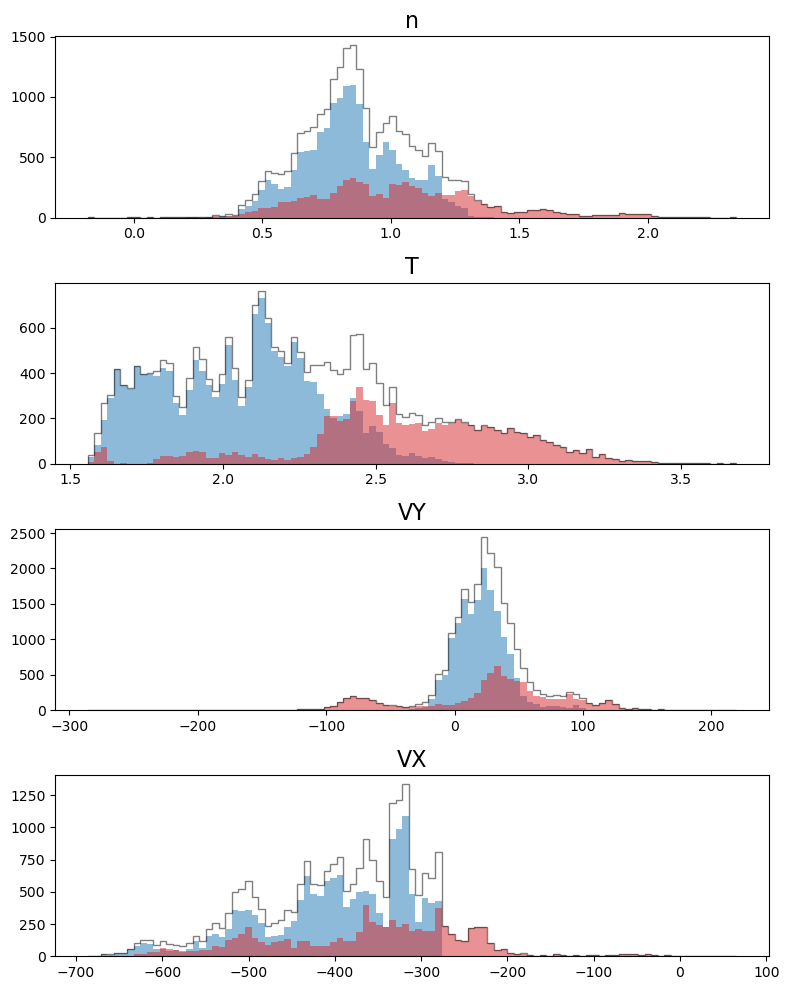

In [16]:
fig, axes = utils.hist1d_vars(subdat, subpreds,
                              hist_vars = ['n','T','VY','VX'],
                              logx      = ['n','T'],
                              fig_kws = {'figsize':(8,10)})
fig.tight_layout()